# DSCI552 HW4

by Kartik Balodi  
Github Username: kartikbalodi  
USC ID: 5317465471

In [1]:
#pip install natsort

In [2]:
#pip install bootstrapped

In [3]:
#pip install scikit-plot

In [4]:
#pip install imbalanced-learn

In [5]:
import pandas as pd
import numpy as np

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

import statsmodels.api as sm
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE 

import os
from natsort import natsorted

import seaborn as sns
import matplotlib.pyplot as plt

## Time Series Classification Part 1: Feature Creation/Extraction
  
**An interesting task in machine learning is classification of time series. In this problem,
we will classify the activities of humans based on time series obtained by a Wireless
Sensor Network.**  

**(a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29**  
  
- **The dataset contains 7 folders that represent seven types of activities.** 
- **In each folder, there are multiple files each of which represents an instant of a human performing an activity. (Some of the data files need very minor cleaning. You can do it by Excel or Python.)** 
- **Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23.** 
- **There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.**

**(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.**

In [6]:
relative_path = "../data/AReM/"
abs_path = os.path.abspath(relative_path)
abs_path = abs_path.replace('\\','/') + '/'

folder_names = []
for i in os.listdir(abs_path):
    if i.endswith('.pdf'):
        continue
    else:
        folder_names.append(i)

folder_path = [abs_path+i+'/' for i in folder_names]

#note now we have two lists folder_names and folder_path

##### Summary of issues in data that I encountered with corresponding solutions:  
- _../data/AReM/cycling/dataset9.csv_ - extra comma on last line, resolved by manually removing extra comma on line 485
- _../data/AReM/cycling/dataset14.csv_ - extra comma on last line, resolved by manually removing extra comma on line 485
- _../data/AReM/sitting/dataset8.csv_ - one line missing for when time=13500 (between lines 59 and 60 in the csv file), I manually inserted the line for time = 13500 in the .csv file, with the data values populated as NaN (empty commaspace in .csv). Then, I fill values using the interpolate method
- _../data/AReM/bending2/dataset4.csv_ - values separated by space instead of comma, code block added in the for loop to account for this file, since it only occurs for one file in the whole dataset

In [7]:
#repeating this cell with fixes for all the data issues caught and elaborated on above, in hw4 I will use just this 
#cell and omit some of the previous ones above since a lot of it served exploratory purposes and the data has been cleaned
#accordingly
#here I add in two new columns called 'activity' and 'sample', which will be used for multi-index/groupby calls in c(ii)

test_df_dict = {}
train_df_dict = {}
columns = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']

for i in range(len(folder_names)):
    file_names = natsorted(os.listdir(folder_path[i]))
    #uses relative_path in the end to find file names
    file_path = [relative_path+folder_names[i]+'/'+j for j in file_names]
    #note now we have file_names and file_path, derived from folder_names[i] and folder_path[i]

    #keep datasets 1 and 2 for testing, rest for training
    if folder_names[i] == 'bending1' or folder_names[i] == 'bending2': 
        #test first
        test_df = pd.DataFrame()
        for j in range(0,2):
            df = pd.read_csv(file_path[j],skiprows=5,header=None,delimiter=',',names=columns)
            df['activity'] = folder_names[i]
            df['sample'] = file_names[j].split('.csv')[0]
            test_df = pd.concat([test_df,df],axis=0)
        test_df_dict[folder_names[i]] = test_df
        
        #train next
        train_df = pd.DataFrame()
        for j in range(2,len(file_names)):
            df = pd.read_csv(file_path[j],skiprows=5,header=None,delimiter=',',names=columns)
            #accounting for the one file that has whitespace as delimiter
            if file_path[j] == '../data/AReM/bending2/dataset4.csv':
                df = pd.read_csv(file_path[j],skiprows=5,header=None,delim_whitespace=True,names=columns)
            df['activity'] = folder_names[i]
            df['sample'] = file_names[j].split('.csv')[0]
            train_df = pd.concat([train_df,df],axis=0)
        train_df_dict[folder_names[i]] = train_df
    
    
    #keep datasets 1,2 and 3 for testing, rest for training
    else: 
        #test first
        test_df = pd.DataFrame()
        for j in range(0,3):
            df = pd.read_csv(file_path[j],skiprows=5,header=None,delimiter=',',names=columns)
            df['activity'] = folder_names[i]
            df['sample'] = file_names[j].split('.csv')[0]
            test_df = pd.concat([test_df,df],axis=0)
        test_df_dict[folder_names[i]] = test_df
        
        #train next
        train_df = pd.DataFrame()
        for j in range(3,len(file_names)):
            df = pd.read_csv(file_path[j],skiprows=5,header=None,delimiter=',',names=columns)
            df['activity'] = folder_names[i]
            df['sample'] = file_names[j].split('.csv')[0]
            train_df = pd.concat([train_df,df],axis=0)
        train_df_dict[folder_names[i]] = train_df 
        
#accounting for the NaN valus for t=13500 from ../data/AReM/sitting/dataset8.csv
df_temp = train_df_dict['sitting']
df_temp = df_temp.interpolate()
train_df_dict['sitting'] = df_temp

In [8]:
for name in folder_names:
    print(name)
    print("train set")
    display(train_df_dict[name].isnull().sum())
    print('test set')
    display(test_df_dict[name].isnull().sum())

bending1
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

bending2
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

cycling
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

lying
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

sitting
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

standing
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

walking
train set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

test set


time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
sample       0
dtype: int64

As desired, no more NaN values are present. Now we can piece this together into one overall test and train dataframe, with multi-indexing to separate activity and sample data corresponding to each activity.

In [9]:
train_df = pd.DataFrame()
for key in train_df_dict.keys():
    train_df = pd.concat([train_df, train_df_dict[key]],axis=0)

test_df = pd.DataFrame()
for key in test_df_dict.keys():
    test_df = pd.concat([test_df, test_df_dict[key]],axis=0)

**(c) Feature Extraction  
Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.**  
  
**i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).**

_Simple statistical features_
- Means in each of the d dimensions
- Standard deviations of the d dimensions
- Skewness, Kurtosis and Higher order moments of the d dimensions
- Maximum and Minimum values + Quantiles (including Median)  
  
_Time series analysis related features_
- The d×d−1 Cross-Correlations between each dimension and the d Auto-Correlations
- Orders of the autoregressive (AR), integrated (I) and moving average (MA) part of an estimated ARIMA model, more specifically the time lag component for AR and MA components and the degree of the delta subtraction operator the I component
- Parameters of the AR part
- Parameters of the MA part  
  
_Frequency domain related features_
- frequencies of the k peaks in amplitude in the Discrete Fourier Transforms (DFTs) for the detrended d dimensions
- k-quantiles of these DFTs  
  
Source: https://stats.stackexchange.com/questions/50807/features-for-time-series-classification

**ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly (You are welcome to experiment to see if they make a difference).**  

In [10]:
combined_df = pd.concat([test_df,train_df],axis=0).set_index(['activity','sample'])
combined_df

time  avg_rss12  var_rss12  avg_rss13  var_rss13  \
activity sample                                                          
bending1 dataset1        0      39.25       0.43      22.75       0.43   
         dataset1      250      39.25       0.43      23.00       0.00   
         dataset1      500      39.25       0.43      23.25       0.43   
         dataset1      750      39.50       0.50      23.00       0.71   
         dataset1     1000      39.50       0.50      24.00       0.00   
...                    ...        ...        ...        ...        ...   
walking  dataset15  118750      34.50       6.18       9.00       3.56   
         dataset15  119000      25.75       6.02      13.75       2.05   
         dataset15  119250      31.50       3.35      10.25       5.12   
         dataset15  119500      33.75       2.77      14.00       3.24   
         dataset15  119750      37.00       1.41      18.25       3.70   

                    avg_rss23  var_rss23  
activity sample                           
bending1 dataset1       33.75       1.30  
         dataset1       33.00       0.00  
         dataset1       33.00       0.00  
         dataset1       33.00       0.00  
         dataset1       33.00       0.00  
...                       ...        ...  
walking  dataset15      12.67       4.19  
         dataset15      16.00       1.58  
         dataset15      16.25       2.95  
         dataset15      13.75       0.43  
         dataset15      11.00       4.32  

[42240 rows x 7 columns]

In [11]:
#drop time axis from table format
desc_df = combined_df.drop('time',axis=1).groupby(['activity', 'sample']).describe()

#change labels of 25%, 50%, 75% to quartiles and medians
desc_df = desc_df.rename(columns=dict(zip(desc_df.columns.levels[1], 
                        ['count','mean','std','min','first quartile','median','third quartile','max'])), level=1)

#drop count from describe() call
tuple1 = ('avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23')
drop_cols = [(i, 'count') for i in tuple1]
desc_df = desc_df.drop('count',axis=1,level=1)

#re-order columns to fit the presentation format
tuple2 = ('min','max','mean','median','std','first quartile','third quartile')
new_order_list = [(i,j) for i in tuple1 for j in tuple2]
desc_df = desc_df[new_order_list]

In [12]:
#using feature data directly
desc_df

avg_rss12                                      \
                        min    max       mean  median       std   
activity sample                                                   
bending1 dataset1     37.25  45.00  40.624792  40.500  1.476967   
         dataset2     38.00  45.67  42.812812  42.500  1.435550   
         dataset3     35.00  47.40  43.954500  44.330  1.558835   
         dataset4     33.00  47.75  42.179813  43.500  3.670666   
         dataset5     33.00  45.75  41.678063  41.750  2.243490   
...                     ...    ...        ...     ...       ...   
walking  dataset5     20.75  46.25  34.763333  35.290  4.742208   
         dataset6     21.50  51.00  34.935813  35.500  4.645944   
         dataset7     18.33  47.67  34.333042  34.750  4.948770   
         dataset8     18.33  45.75  34.599875  35.125  4.731790   
         dataset9     15.50  43.67  34.225875  34.750  4.441798   

                                                var_rss12                   \
                  first quartile third quartile       min    max      mean   
activity sample                                                              
bending1 dataset1          39.25        42.0000       0.0   1.30  0.358604   
         dataset2          42.00        43.6700       0.0   1.22  0.372438   
         dataset3          43.00        45.0000       0.0   1.70  0.426250   
         dataset4          39.15        45.0000       0.0   3.00  0.696042   
         dataset5          41.33        42.7500       0.0   2.83  0.535979   
...                          ...            ...       ...    ...       ...   
walking  dataset5          31.67        38.2500       0.0  12.68  4.223792   
         dataset6          32.00        38.0625       0.0  12.21  4.115750   
         dataset7          31.25        38.0000       0.0  12.48  4.396958   
         dataset8          31.50        38.0000       0.0  15.37  4.398833   
         dataset9          31.25        37.2500       0.0  17.24  4.354500   

                   ... avg_rss23                               var_rss23  \
                   ...       std first quartile third quartile       min   
activity sample    ...                                                     
bending1 dataset1  ...  2.188449        33.0000          36.00       0.0   
         dataset2  ...  1.995255        32.0000          34.50       0.0   
         dataset3  ...  1.999604        35.3625          36.50       0.0   
         dataset4  ...  3.849448        30.4575          36.33       0.0   
         dataset5  ...  2.411026        28.4575          31.25       0.0   
...                ...       ...            ...            ...       ...   
walking  dataset5  ...  3.174681        14.2500          18.33       0.0   
         dataset6  ...  3.192058        14.2375          18.25       0.0   
         dataset7  ...  3.000493        13.7500          18.00       0.0   
         dataset8  ...  2.905688        14.0000          18.25       0.0   
         dataset9  ...  2.992920        14.3300          18.25       0.0   

                                                                    \
                     max      mean median       std first quartile   
activity sample                                                      
bending1 dataset1   1.92  0.570583  0.430  0.582915           0.00   
         dataset2   3.11  0.571083  0.430  0.601010           0.00   
         dataset3   1.79  0.493292  0.430  0.513506           0.00   
         dataset4   2.18  0.613521  0.500  0.524317           0.00   
         dataset5   1.79  0.383292  0.430  0.389164           0.00   
...                  ...       ...    ...       ...            ...   
walking  dataset5   9.39  3.288271  3.270  1.647528           2.05   
         dataset6  10.21  3.280021  3.015  1.700918           2.12   
         dataset7   8.01  3.261583  2.980  1.617290           2.05   
         dataset8   8.86  3.289542  3.015  1.680170           2.12   
         da

In [13]:
#using min-max normalization on features
minmax_normalized_df=(desc_df-desc_df.min())/(desc_df.max()-desc_df.min())
minmax_normalized_df

avg_rss12                                          \
                        min       max      mean    median       std   
activity sample                                                       
bending1 dataset1  0.776042  0.571429  0.685196  0.684211  0.188828   
         dataset2  0.791667  0.596952  0.778537  0.768421  0.183415   
         dataset3  0.729167  0.662857  0.827242  0.845474  0.199526   
         dataset4  0.687500  0.676190  0.751534  0.810526  0.475507   
         dataset5  0.687500  0.600000  0.730129  0.736842  0.288999   
...                     ...       ...       ...       ...       ...   
walking  dataset5  0.432292  0.619048  0.435147  0.464842  0.615539   
         dataset6  0.447917  0.800000  0.442505  0.473684  0.602959   
         dataset7  0.381875  0.673143  0.416791  0.442105  0.642533   
         dataset8  0.381875  0.600000  0.428174  0.457895  0.614177   
         dataset9  0.322917  0.520762  0.412219  0.442105  0.576280   

                                                var_rss12                      \
                  first quartile third quartile       min       max      mean   
activity sample                                                                 
bending1 dataset1       0.647355       0.563636       NaN  0.051755  0.076911   
         dataset2       0.758186       0.624364       NaN  0.046996  0.079939   
         dataset3       0.798489       0.672727       NaN  0.075550  0.091715   
         dataset4       0.643325       0.672727       NaN  0.152885  0.150758   
         dataset5       0.731184       0.590909       NaN  0.142772  0.115729   
...                          ...            ...       ...       ...       ...   
walking  dataset5       0.341864       0.427273       NaN  0.728733  0.922797   
         dataset6       0.355164       0.420455       NaN  0.700773  0.899152   
         dataset7       0.324937       0.418182       NaN  0.716835  0.960694   
         dataset8       0.335013       0.418182       NaN  0.888757  0.961104   
         dataset9       0.324937       0.390909       NaN  1.000000  0.951402   

                   ... avg_rss23                               var_rss23  \
                   ...       std first quartile third quartile       min   
activity sample    ...                                                     
bending1 dataset1  ...  0.072449       0.931248       0.983849       0.0   
         dataset2  ...  0.040816       0.902146       0.935395       0.0   
         dataset3  ...  0.041529       1.000000       1.000000       0.0   
         dataset4  ...  0.344411       0.857257       0.994509       0.0   
         dataset5  ...  0.108892       0.799054       0.830413       0.0   
...                ...       ...            ...            ...       ...   
walking  dataset5  ...  0.233929       0.385595       0.413066       0.0   
         dataset6  ...  0.236774       0.385231       0.410482       0.0   
         dataset7  ...  0.205408       0.371044       0.402407       0.0   
         dataset8  ...  0.189886       0.378319       0.410482       0.0   
         dataset9  ...  0.204168       0.387923       0.410482       0.0   

                                                                          \
                        max      mean    median       std first quartile   
activity sample                                                            
bending1 dataset1  0.010998  0.059510  0.000000  0.123495       0.000000   
         dataset2  0.111675  0.059669  0.000000  0.134981       0.000000   
         dataset3  0.000000  0.034952  0.000000  0.079434       0.000000   
         dataset4  0.032995  0.073153  0.024055  0.086297       0.000000   
         dataset5  0.000000  0.000000  0.000000  0.000503       0.000000   
...                     ...       ...       ...       ...            ...   
walking  dataset5  0.642978  0.923034  0.975945  0.799305       0.915179   
         dataset6  0.712352  0.920412  0.888316  0.833197      

In [14]:
#using mean normalization/z-stats on features
mean_normalized_df=(desc_df-desc_df.mean())/desc_df.std()
mean_normalized_df

avg_rss12                                          \
                        min       max      mean    median       std   
activity sample                                                       
bending1 dataset1  0.858236 -0.107653  0.320006  0.302073 -0.853155   
         dataset2  0.936606  0.044815  0.730077  0.669717 -0.876526   
         dataset3  0.623125  0.438501  0.944049  1.006110 -0.806959   
         dataset4  0.414139  0.518148  0.611442  0.853538  0.384715   
         dataset5  0.414139  0.063020  0.517406  0.531850 -0.420618   
...                     ...       ...       ...       ...       ...   
walking  dataset5 -0.865907  0.176802 -0.778530 -0.655638  0.989370   
         dataset6 -0.787536  1.257733 -0.746204 -0.617035  0.935050   
         dataset7 -1.118781  0.499943 -0.859174 -0.754901  1.105930   
         dataset8 -1.118781  0.063020 -0.809165 -0.685968  0.983491   
         dataset9 -1.414497 -0.410314 -0.879258 -0.754901  0.819853   

                                                var_rss12                      \
                  first quartile third quartile       min       max      mean   
activity sample                                                                 
bending1 dataset1       0.362418       0.156216       NaN -0.985657 -0.699103   
         dataset2       0.809311       0.481187       NaN -1.001459 -0.690315   
         dataset3       0.971818       0.739996       NaN -0.906648 -0.656130   
         dataset4       0.346167       0.739996       NaN -0.649870 -0.484744   
         dataset5       0.700432       0.302161       NaN -0.683448 -0.586424   
...                          ...            ...       ...       ...       ...   
walking  dataset5      -0.869384      -0.573508       NaN  1.262143  1.756279   
         dataset6      -0.815756      -0.609995       NaN  1.169307  1.687645   
         dataset7      -0.937636      -0.622157       NaN  1.222638  1.866284   
         dataset8      -0.897010      -0.622157       NaN  1.793477  1.867475   
         dataset9      -0.937636      -0.768102       NaN  2.162843  1.839312   

                   ... avg_rss23                               var_rss23  \
                   ...       std first quartile third quartile       min   
activity sample    ...                                                     
bending1 dataset1  ... -1.316513       3.144976       3.158473   -0.1066   
         dataset2  ... -1.505019       2.980947       2.887310   -0.1066   
         dataset3  ... -1.500775       3.532496       3.248861   -0.1066   
         dataset4  ...  0.304175       2.727931       3.218129   -0.1066   
         dataset5  ... -1.099337       2.399872       2.299789   -0.1066   
...                ...       ...            ...            ...       ...   
walking  dataset5  ... -0.354216       0.069424      -0.035832   -0.1066   
         dataset6  ... -0.337261       0.067373      -0.050294   -0.1066   
         dataset7  ... -0.524177      -0.012591      -0.095488   -0.1066   
         dataset8  ... -0.616681       0.028416      -0.050294   -0.1066   
         dataset9  ... -0.531566       0.082546      -0.050294   -0.1066   

                                                                          \
                        max      mean    median       std first quartile   
activity sample                                                            
bending1 dataset1 -1.803126 -0.909413 -0.934685 -0.899806      -1.189080   
         dataset2 -1.330701 -0.908980 -0.934685 -0.864846      -1.189080   
         dataset3 -1.854735 -0.976345 -0.934685 -1.033913      -1.189080   
         dataset4 -1.699907 -0.872230 -0.870257 -1.013025      -1.189080   
         dataset5 -1.854735 -1.071602 -0.934685 -1.274156      -1.189080   
...                     ...       ...       ...       ...            ...   
walking  dataset5  1.162430  1.444029  1.679275  1.157149       1.513324   
         dataset6  1.487966  1.436885  1.444570  1.260305      

**iii. Estimate the standard deviation of each of the time-domain features you
extracted from the data. Then, use Python’s bootstrapped or any other
method to build a 90% bootstrap confidence interval for the standard deviation
of each feature.**  
  
Resources consulted:
- https://pypi.org/project/bootstrapped/
- https://github.com/facebookarchive/bootstrapped/blob/master/bootstrapped/bootstrap.py (search for 'def bootstrap')

In [15]:
feature_stdev_list = desc_df.std()
bootstrap_list = [] #in case I need to use this in future parts of the assignment
for i in range(len(feature_stdev_list)):
    col_name = (tuple1[i//7],tuple2[i%7])

    #bs.bootstrap(samples, stat_func=bs_stats.std)
    ret = np.array([])
    ret = bs.bootstrap(desc_df[col_name].to_numpy(), stat_func=bs_stats.std, alpha=0.1, num_iterations=10000)
    bootstrap_list.append((col_name,ret)) #in case I need to use this in future parts of the assignment
    print(col_name)
    print(ret)
    print()

('avg_rss12', 'min')
9.515445066931841    (8.333881928362803, 10.809469774262183)

('avg_rss12', 'max')
4.36932238296287    (3.4786952064588688, 5.4391963079801)

('avg_rss12', 'mean')
5.305300142199838    (4.775362066797559, 5.9374510560098885)

('avg_rss12', 'median')
5.409056425357996    (4.859212704811566, 6.053775684638049)

('avg_rss12', 'std')
1.7620574921772343    (1.5843207461092677, 1.9618399118935999)

('avg_rss12', 'first quartile')
6.118526249454473    (5.626254367692242, 6.692687897604517)

('avg_rss12', 'third quartile')
5.109642753365408    (4.418873399520548, 5.905835732281734)

('var_rss12', 'min')
0.0    (0.0, 0.0)

('var_rss12', 'max')
5.033881679163113    (4.698740289178693, 5.464584709520285)

('var_rss12', 'mean')
1.565199957842158    (1.4352748415446992, 1.7471282861116135)

('var_rss12', 'median')
1.4041971241720508    (1.2726226572252728, 1.5730459497056173)

('var_rss12', 'std')
0.8790661169601129    (0.8219813954577969, 0.9605031924700185)

('var_rss12', 'fi

**iv. Use your judgement to select the three most important time-domain features
(one option may be min, mean, and max).**  
  
From studying the mean-normalized and min-max-normalized data in detail, I believe that mean, standard deviation and the range (i.e. max-min), represent the three most important time-domain features.  

The reason I back these features is that the mean and standard deviation gives us an intuition for the spread of the time-series feature. Adding the range information on top gives us a feeling for outliers and skewness, given the assumption that the time-series features follow some form of normal/Symmetric Alpha-Stable distribution. If we incude the IQR, we might have some intuition for the kurtosis as well, but I reason that this is not as crucial because the range under mean/z-stat normalization has a max-min value <= 2 in most cases based on the observed data, so the spread across features does not warrant a deeper analysis of kurtosis behavior as of now.  
  
If max and min count as two time-domain features in my justification above, I would like to substitute that with the median. The closer the median is to the mean, in general the more symmetric our curve. If median < mean, it is likely that the data has a longer right-tail, and if median > mean, it is likely that the data has a longer left-tail - which gives us some intuition about the general skewness of the time-series data.  
  
Thus,
- mean
- standard deviation
- range = (max-min), or median (if range counts as two time-domain features)

## 2. Time Series Classification Part 2: Binary and Multiclass Classification
  
**(a) Binary Classification Using Logistic Regression  
(Some logistic regression packages have a built-in L2 regularization. To remove the effect of L2 regularization, set λ = 0 or set the budget C → ∞ (i.e. a very large value).)**  
  
**i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).  
(You are welcome to repeat this experiment with other features as well as with time series 3, 4, and 5 in each instance.)**

In [16]:
train_df

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,activity,sample
0,0,42.00,0.71,21.25,0.43,30.00,0.00,bending1,dataset3
1,250,41.50,0.50,20.25,1.48,31.25,1.09,bending1,dataset3
2,500,41.50,0.50,14.25,1.92,33.00,0.00,bending1,dataset3
3,750,40.75,0.83,15.75,0.43,33.00,0.00,bending1,dataset3
4,1000,40.00,0.71,20.00,2.74,32.75,0.43,bending1,dataset3
...,...,...,...,...,...,...,...,...,...
475,118750,34.50,6.18,9.00,3.56,12.67,4.19,walking,dataset15
476,119000,25.75,6.02,13.75,2.05,16.00,1.58,walking,dataset15
477,119250,31.50,3.35,10.25,5.12,16.25,2.95,walking,dataset15
478,119500,33.75,2.77,14.00,3.24,13.75,0.43,walking,dataset15


In [17]:
def get_instance_stats_binary_classification_bending(df, stats_type_list, describe_df, bending_status):
    for i in range(0,len(df),480):
        instance_stats = df.iloc[i:i+480].describe()
        instance_df = pd.DataFrame()
        for j in stats_type_list:
            single_stats = pd.DataFrame(data=[instance_stats.loc[j].tolist()],
                                        columns=[j+"_"+str(i) for i in instance_stats.columns])
            instance_df = pd.concat([instance_df,single_stats],axis=1)
        instance_df['bending_status'] = bending_status
        describe_df = pd.concat([describe_df,instance_df],ignore_index=True)
    return describe_df

In [18]:
stats_type_list = ['mean','std','50%']

describe_df = pd.DataFrame()
train_df_bending = train_df.loc[(train_df['activity'] == 'bending1') | (train_df['activity'] == 'bending2')].drop(
    ['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)
describe_df = get_instance_stats_binary_classification_bending(
    train_df_bending, stats_type_list, describe_df, bending_status='bending')

train_df_not_bending = train_df.loc[(train_df['activity'] != 'bending1') & (train_df['activity'] != 'bending2')].drop(
['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)
describe_df = get_instance_stats_binary_classification_bending(
    train_df_not_bending, stats_type_list, describe_df, bending_status='not_bending')

describe_df

,mean_avg_rss12,mean_var_rss12,mean_var_rss23,std_avg_rss12,std_var_rss12,std_var_rss23,50%_avg_rss12,50%_var_rss12,50%_var_rss23,bending_status
0,43.954500,0.426250,0.493292,1.558835,0.338690,0.513506,44.33,0.470,0.43,bending
1,42.179813,0.696042,0.613521,3.670666,0.630860,0.524317,43.50,0.500,0.50,bending
2,41.678063,0.535979,0.383292,2.243490,0.405469,0.389164,41.75,0.500,0.43,bending
3,43.454958,0.378083,0.679646,1.386098,0.315566,0.622534,43.25,0.470,0.50,bending
4,43.969125,0.413125,0.555313,1.618364,0.263111,0.487826,44.50,0.470,0.49,bending
...,...,...,...,...,...,...,...,...,...,...
64,33.586875,4.576562,3.259729,4.650935,2.461077,1.640243,34.25,4.260,3.11,not_bending
65,34.322750,4.456333,3.432562,4.752477,2.599284,1.732727,35.25,3.900,3.20,not_bending
66,34.546229,4.371958,3.338125,4.842294,2.360448,1.656742,35.25,4.135,3.08,not_bending
67,34.873229,4.380583,3.424646,4.531720,2.435437,1.690960,35.25,3.925,3.27,not_bending


Text(0.5, 0.98, 'Time Domain Features')

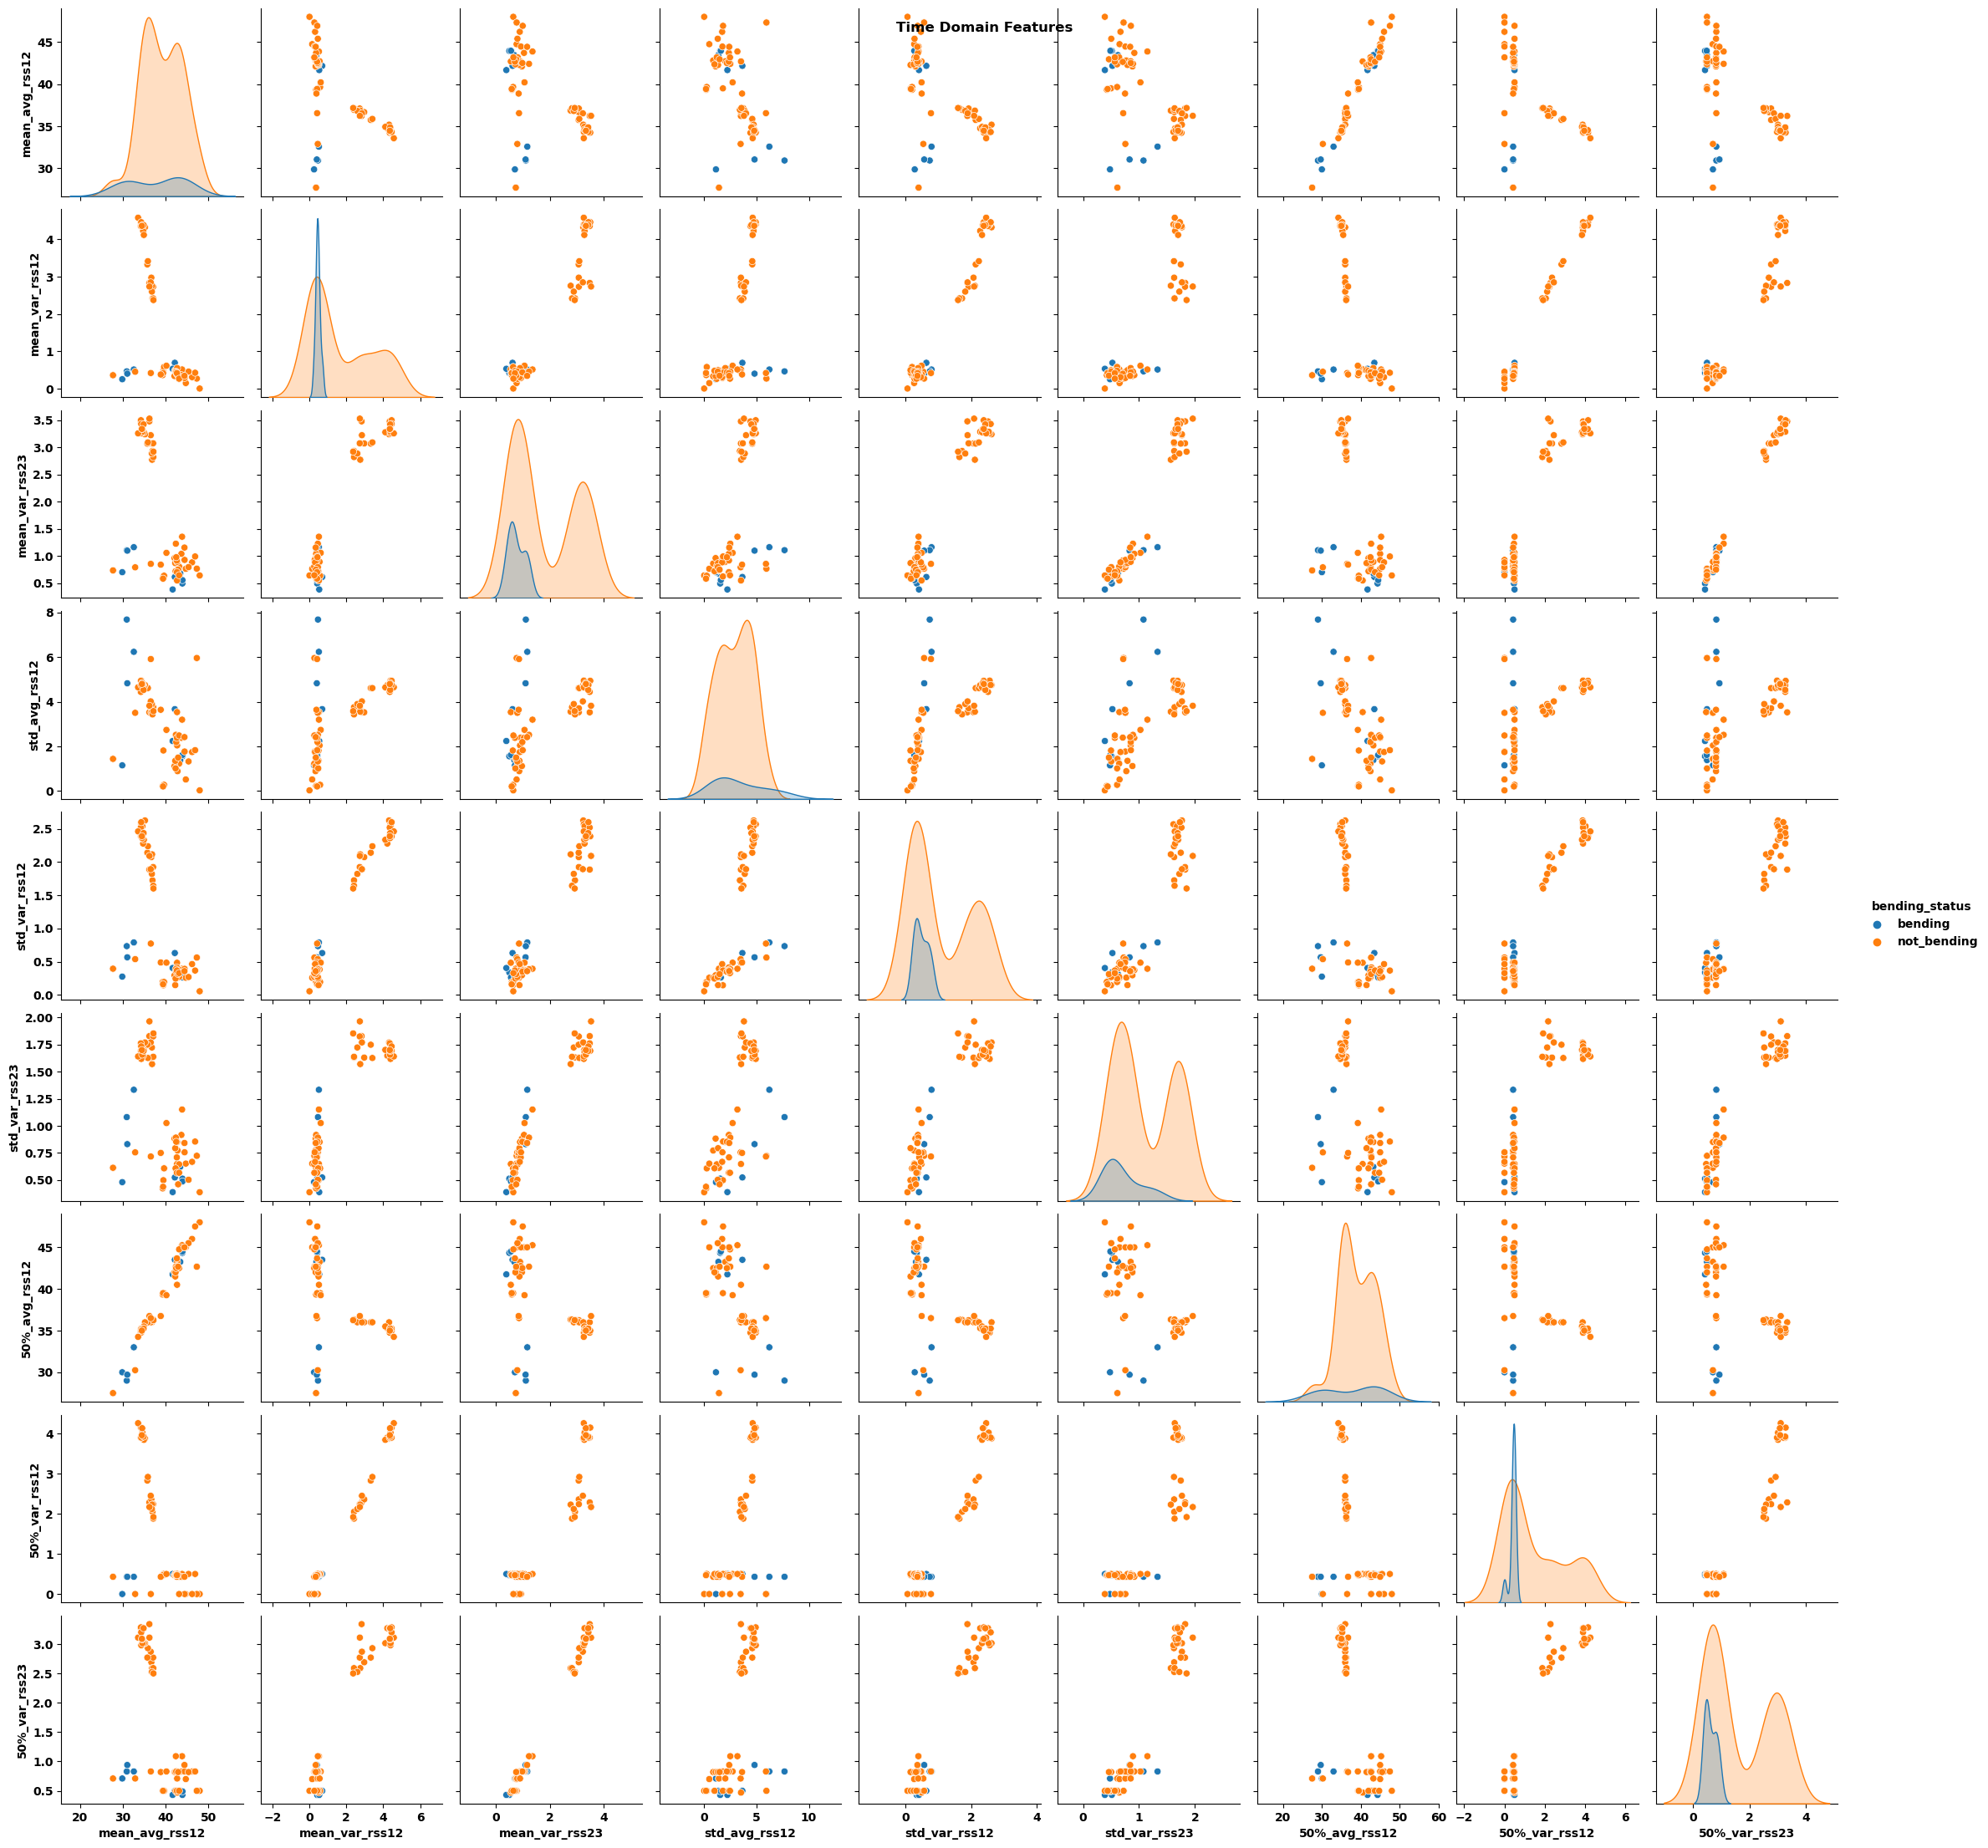

In [19]:
ax = sns.pairplot(describe_df, hue='bending_status')
ax.fig.suptitle("Time Domain Features")

**ii. Break each time series in your training set into two (approximately) equal
length time series. Now instead of 6 time series for each of the training
instances, you have 12 time series for each training instance. Repeat the
experiment in 2(a)i, i.e depict scatter plots of the features extracted from both
parts of the time series 1,2, and 6. Do you see any considerable difference in
the results with those of 2(a)i?**

Each time series has exactly 480 points, so here I will redesign my function get_instance_stats_binary_classification_bending to account for k splits of the 480-point time series moving forward. Note that when k does not divide perfectly with 480 (as in the case of prime numbers for example), I will have the remainder terms of the time series in the kth (final) split of the time series)

In [20]:
def get_instance_stats_binary_classification_bending_ksplits(
    input_df, stats_type_list, return_df, bending_status, k_splits):
    
    describe_df = pd.DataFrame()
    step_size = 480//k_splits #note here that k_splits must be a divisor of 480
    
    #first split the dataframe into equal length time series
    splitted_input_df_list = [pd.DataFrame() for j in range(k_splits)]
    for i in range(0,len(input_df),480):
        for j in range(k_splits):
            df = input_df.loc[ (input_df.index >= i+j*step_size) & (input_df.index < i+(j+1)*step_size) ]
            if j == k_splits-1:
                df = input_df.loc[ (input_df.index >= i+j*step_size) & (input_df.index < 480) ]
            splitted_input_df_list[j] = pd.concat([splitted_input_df_list[j],df],axis=0)
    
    #repeat step from a(i) with each split df
    for i in range(len(splitted_input_df_list)): #for each equal-length i= to i=k time-series
        split_df = splitted_input_df_list[i]
        
        #accounts for any uneven splitting for the final split of the initial time series
        step_size2 = 480//k_splits
        if i == k_splits-1:
            step_size2 = 480//k_splits + 480%k_splits
        
        temp_df = pd.DataFrame()

        for j in range(0,len(split_df), step_size2): #for each of the j instances in the equal-length time series
            instance_stats = split_df.iloc[j:j+step_size2].describe()
            instance_df = pd.DataFrame()
            
            for k in stats_type_list: #for each stat we demand
                single_stats = pd.DataFrame(data=[instance_stats.loc[k].tolist()],
                                            columns=[k+"_"+str(l+i*6) for l in [1,2,6]]) #label ith split as 'split_i'
                instance_df = pd.concat([instance_df,single_stats],axis=1) #concat each stat by column
            
            temp_df = pd.concat([temp_df,instance_df],ignore_index=True) #concat here by row corresponding to each instance
            
        describe_df = pd.concat([describe_df,temp_df],axis=1) #concat by column to append results of each instance columnwise
    
    describe_df['bending_status'] = bending_status
    return_df = pd.concat([return_df,describe_df],ignore_index=True)
    
    return return_df

In [21]:
describe_df = pd.DataFrame()

describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_bending, stats_type_list, describe_df, bending_status='bending', k_splits=2)
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_not_bending, stats_type_list, describe_df, bending_status='not_bending', k_splits=2)

describe_df

,mean_1,mean_2,mean_6,std_1,std_2,std_6,50%_1,50%_2,50%_6,mean_7,mean_8,mean_12,std_7,std_8,std_12,50%_7,50%_8,50%_12,bending_status
0,44.057167,0.381042,0.598250,1.556971,0.329540,0.526656,44.500,0.470,0.500,43.851833,0.471458,0.388333,1.557168,0.342346,0.478528,43.500,0.500,0.000,bending
1,43.278875,0.673292,0.640958,3.473355,0.634285,0.554542,45.000,0.485,0.765,41.080750,0.718792,0.586083,3.537481,0.627915,0.491873,42.000,0.500,0.470,bending
2,41.621208,0.623083,0.419083,3.118644,0.489595,0.411200,42.330,0.500,0.430,41.734917,0.448875,0.347500,0.595920,0.273050,0.363144,41.500,0.500,0.430,bending
3,44.117042,0.250042,0.815417,1.359836,0.314099,0.718016,45.000,0.000,0.710,42.792875,0.506125,0.543875,1.058792,0.260761,0.473445,42.670,0.500,0.500,bending
4,43.486208,0.378667,0.524875,1.281976,0.284434,0.486847,43.710,0.470,0.470,44.452042,0.447583,0.585750,1.771251,0.235493,0.487918,44.500,0.500,0.500,bending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,33.334500,4.408083,3.229167,4.874433,2.196206,1.637310,34.000,4.195,3.110,33.839250,4.745042,3.290292,4.411903,2.694219,1.646023,34.500,4.320,3.155,not_bending
65,34.036750,4.778292,3.543708,4.872880,2.762730,1.703098,34.415,4.030,3.255,34.608750,4.134375,3.321417,4.621400,2.387460,1.758379,35.500,3.740,3.155,not_bending
66,34.033875,4.574625,3.244042,4.758757,2.391804,1.619767,35.000,4.470,2.980,35.058583,4.169292,3.432208,4.880650,2.315929,1.691050,35.875,3.880,3.255,not_bending
67,34.920792,4.177958,3.430625,4.272282,2.341763,1.781928,35.330,3.865,3.270,34.825667,4.583208,3.418667,4.785599,2.514203,1.598536,35.250,4.070,3.350,not_bending


Text(0.5, 0.98, 'Time Domain Features')

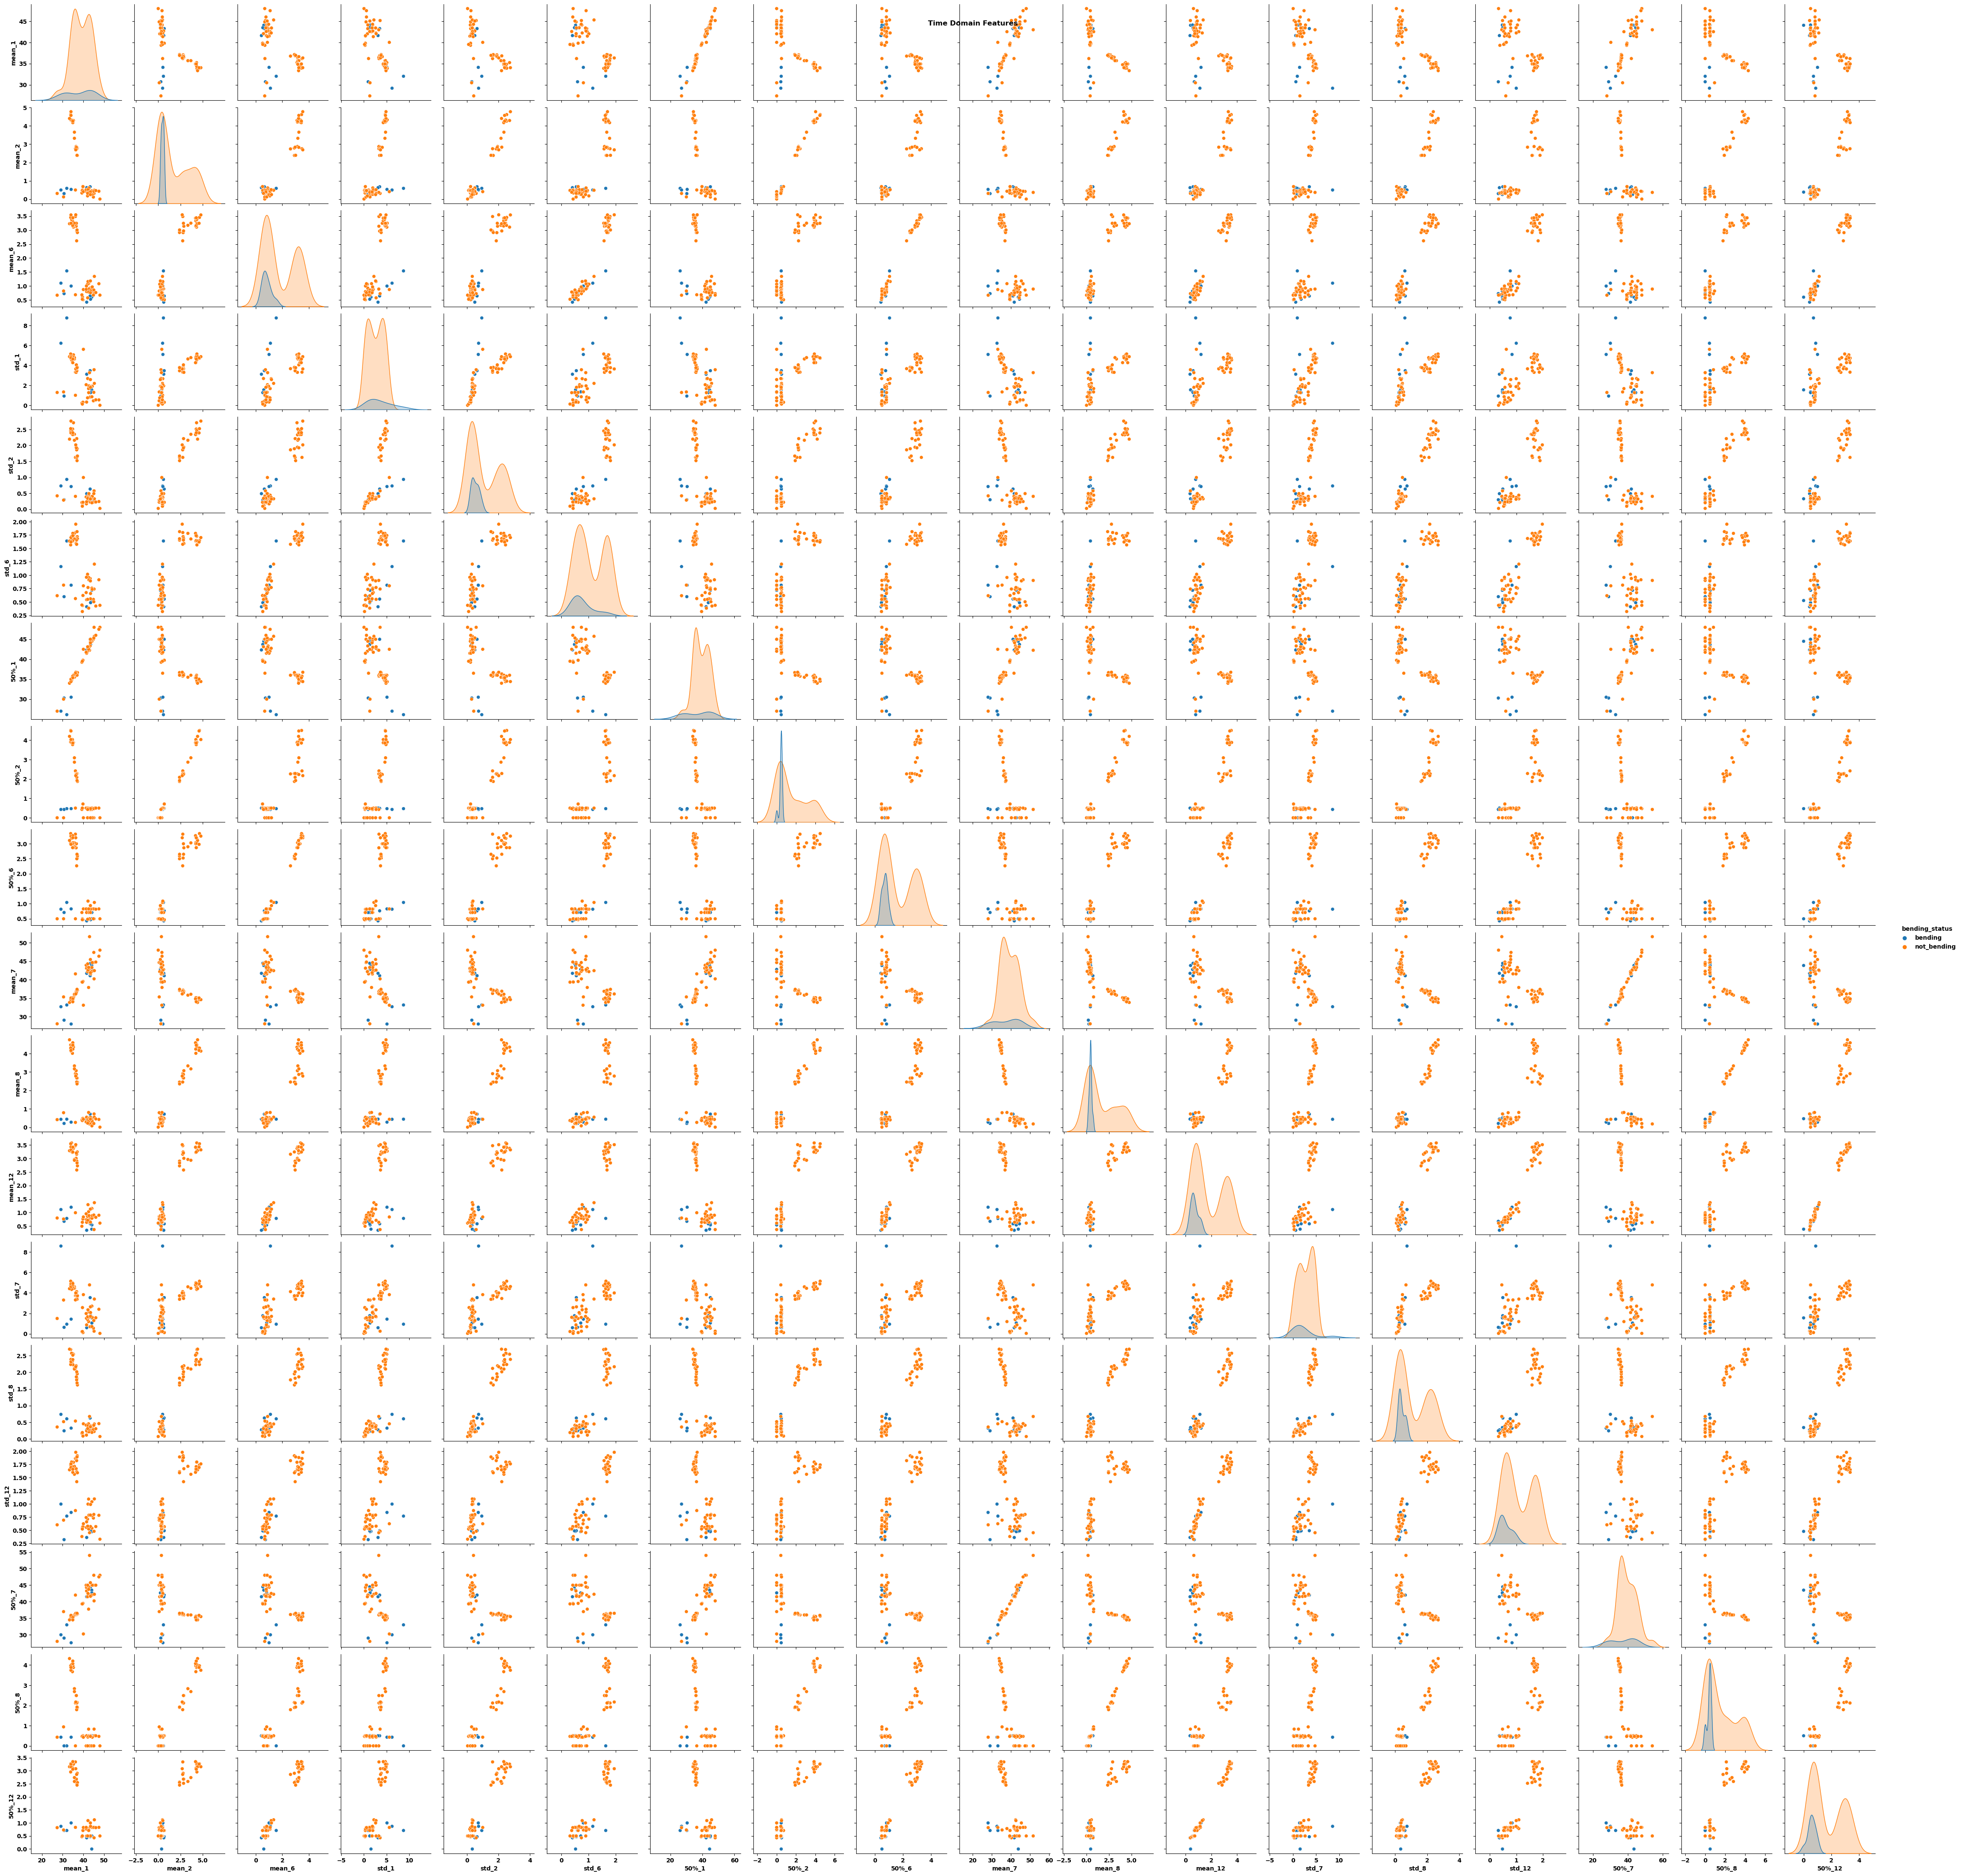

In [22]:
ax = sns.pairplot(describe_df, hue='bending_status')
ax.fig.suptitle("Time Domain Features")

**Do you see any considerable difference in the results with those of 2(a)i?**  

There are more features present (twice the amount than before) so we are able to find more ways to split the 69 samples into separable groups, apart from that the scatterplots individually seem fairly similar to me.
<!-- The data points are more sparse in this situation and since bending has fewer datapoints than not bending in the training set, the bending class stands out more visibly than before in this situation. -->

**iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series
of approximately equal length and use logistic regression (If you encountered instability of the logistic regression problem because of linearly separable classes, modify the Max-Iter parameter in logistic regression to stop the algorithm immaturely and prevent from its instability.) to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance.**  
  
**Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. (R calculates the p-values for logistic regression automatically. One way of calculating them in Python is to call R within Python. There are other ways to obtain the p-values as well.) Alternatively, you can use backward selection using sklearn.feature selection or glm in R.**  
  
**Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. (This is an interesting problem in which the number of features changes depending on the value of the parameter l that is selected via cross validation. Another example of such a problem is Principal Component Regression, where the number of principal components is selected via cross validation.) Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.**

Notes: 
- The code block below will take a few minutes (around three minutes for me) to run. 
- I played around with the max_iter parameter in increments of 100. The more max_iters I ran, the fewer failed to converge warnings I got, and the first minimum max_iter without warnings I got was at max_iter = 600 (which I've used below).
- I ran RFE instead of RFECV below (even though some comments on Piazza suggested otherwise), because I called the StratifiedKFolds outside the second/inner for loop. I felt that in order to correctly perform cross-validation, it was important that I call StratifiedKfolds first then run RFE on each - at which point it would be redundant to call cross-validation a second time in the inner for loop (through using RFECV).
- I find that AUC is a more robust metric than accuracy, so I initially opted to use argmax(AUC) for best feature set P for each L and argmax(mean_AUC_from_5-fold_cross-val) for best L in determining the best (L,P) pair. EDIT: from piazza @764: "ROC and AUC is a good measure to evaluate your model post training. The goal here is to choose the l,p while training the model. Which is why, we use Cross validation. So i think CV score is the better measure to pick l,p." Thus, I will use argmax(mean_accuracy_from_5-fold_cross-val) for best L in determining the best (L,P) pair
- (piazza @764 follow-up) For choosing the best feature set P from the 5 folds, when we do 5-fold cross-validation for each L, we get 5 similar (but sometimes slightly different) feature sets. Is it wiser to go with the one with the smallest size (to avoid overfitting hopefully when we get to the test set), or the one with best accuracy (or AUC post training) and if there are ties picking the smallest set size? I collected data for both for further analysis here  
  
Main Resources Consulted:
- Lesson 3 Classification Lecture Notes
- Lesson 4 Resampling Lecture Notes
- https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
- https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
- https://machinelearningmastery.com/rfe-feature-selection-in-python/
- https://stats.stackexchange.com/questions/254124/why-does-logistic-regression-become-unstable-when-classes-are-well-separated
- https://www.quora.com/scikit-learn-How-does-RFECV-make-use-of-cross-validation
- https://www.ibm.com/support/pages/it-safe-interpret-my-logistic-regression-results-when-maximum-iterations-have-been-reached
- https://stackoverflow.com/questions/57085897/python-logistic-regression-max-iter-parameter-is-reducing-the-accuracy
- https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
- https://scikit-learn.org/stable/modules/preprocessing.html
- https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [23]:
#I'm changing up the values here to see if there's any significant difference between our selected features
stats_type_list = ['mean','std','50%']

In [24]:
#these lists will give us the best results for all choices of l from 1 to 20
accuracy_list = []
best_features1 = []

for l in range(1,21): #for each choice of l
    
    #split our time series into equal sized groups using l as our split-size and generate our training data
    describe_df = pd.DataFrame()
    describe_df = get_instance_stats_binary_classification_bending_ksplits(
        train_df_bending, stats_type_list, describe_df, bending_status=1, k_splits=l)
    describe_df = get_instance_stats_binary_classification_bending_ksplits(
        train_df_not_bending, stats_type_list, describe_df, bending_status=0, k_splits=l)
    X_train = describe_df.drop('bending_status',axis=1)
    y_train = describe_df['bending_status']
    
    #create our 5-fold stratified cross-validation model first to be able to run recursive feature elimination on each fold
    #in order to determine the best predictor based on results of RFE on each fold.
        
    #run first logistic regression with recursive feature elimination
    #remove default L2-Regularization penalty (as suggested in footnote 3), set max_iter > default 100 to reduce instability
    lrm_one = LogisticRegression(penalty='none', max_iter=600) 
    selector = RFECV(estimator=lrm_one, cv=StratifiedKFold(5))
    selector = selector.fit(X_train,y_train)
    best_features = selector.fit(X_train,y_train).support_

    #run second logistic regression with prunes set of features
    #remove default L2-Regularization penalty (as suggested in footnote 3), set max_iter > default 100 to reduce instability
    lrm_two = LogisticRegression(penalty='none', max_iter=600)
    X_train = X_train.loc[:,best_features]
    lrm_two.fit(X_train,y_train)

    
    best_features1.append(X_train.columns.tolist())
    accuracy_list.append(lrm_two.score(X_train,y_train))

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

**Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. (This is an interesting problem in which the number of features changes depending on the value of the parameter l that is selected via cross validation. Another example of such a problem is Principal Component Regression, where the number of principal components is selected via cross validation.) Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.**  
  
We already know that the bending class is imbalanced compared to the non-bending class (9 instances vs 60) - so given that I opted for Stratified Cross Validation.  
  
The wrong way to cross-validate would be to do some form of feature selection prior by first running logistic regression, then picking our k-folds for cross-validation from the set of predictors and then refitting the logistic regression. In doing so, the first logistic regression procedure has already seen the labels of the training data, and made use of them, which is a form of training and must be included in the validation process. Cross-validation must be a part of the feature elimination process otherwise we will be training on conditioned information. The correct way to run k-fold cross validation will be to first select the k-folds from the set in an ideally stratified manner so that each fold has a fair representation of the proportions of each class, and then running logistic regression with recursive feature elimination, after which we try to refit the logistic regression using the pruned set of features.  

In [25]:
len_best_feature_set = [len(i) for i in best_features1]

results_df = pd.DataFrame({"L":range(1,21), "Mean 5-Fold Accuracy":accuracy_list, "Best Feature Set":best_features1, 
                          "Set Size":len_best_feature_set})
results_df = results_df.set_index("L")
best_LP = results_df.loc[ (results_df['Mean 5-Fold Accuracy'] == results_df['Mean 5-Fold Accuracy'].max()) ]
# best_LP = best_LP.loc[ best_LP['Set Size'] == best_LP['Set Size'].min()  ]

print('Best L:', best_LP.index[0])
print('\nBest Feature Set (by accuracy from the 5-folds) P:')
print(best_LP['Best Feature Set'].iloc[0])
print("\nFeature Set Length:", len(best_LP['Best Feature Set'].iloc[0]))

l = best_LP.index[0]
p = len(best_LP['Best Feature Set'].iloc[0])

print("Best (l,p) pair:", (l, p))

Best L: 2

Best Feature Set (by accuracy from the 5-folds) P:
['mean_1', 'mean_2', 'mean_6', 'std_1', 'std_2', 'std_6', '50%_1', '50%_2', '50%_6', 'mean_7', 'mean_8', 'mean_12', 'std_7', 'std_8', 'std_12', '50%_8', '50%_12']

Feature Set Length: 17
Best (l,p) pair: (2, 17)


**iv. Report the confusion matrix and show the ROC and AUC for your classifier
on train data. Report the parameters of your logistic regression βi
’s as well
as the p-values associated with them.**

In [26]:
best_features = best_LP['Best Feature Set'].iloc[0]

describe_df = pd.DataFrame()
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_bending, stats_type_list, describe_df, bending_status=1, k_splits=l)
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    train_df_not_bending, stats_type_list, describe_df, bending_status=0, k_splits=l)

train_X = describe_df[best_features]
train_y = describe_df['bending_status']

In [27]:
lrm = LogisticRegression(penalty='none', max_iter=100)
lrm.fit(train_X, train_y)

train_y_predictions = lrm.predict(train_X)

print('Accuracy \n', lrm.score(train_X,train_y))
print('Confusion Matrix \n', metrics.confusion_matrix(train_y,train_y_predictions))

Accuracy 
 0.9565217391304348
Confusion Matrix 
 [[59  1]
 [ 2  7]]


C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


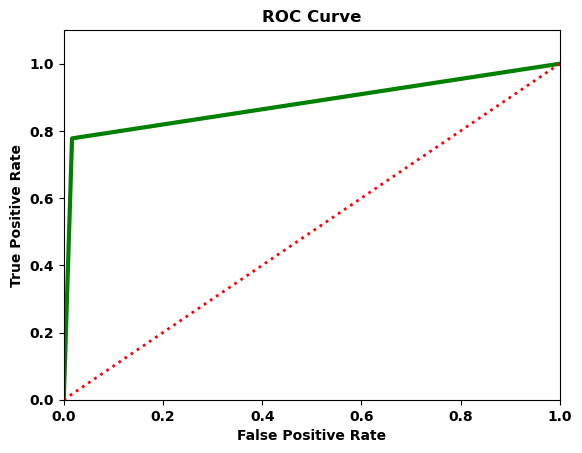

auc: 0.8805555555555555


In [28]:
fpr,tpr,thres = metrics.roc_curve(train_y,train_y_predictions)
auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='green',lw=3)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print("auc:", auc)

**Report the parameters of your logistic regression βi
’s as well
as the p-values associated with them.**  
  
Resources Consulted:
- https://stackoverflow.com/questions/22306341/python-sklearn-how-to-calculate-p-values
- https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html
- https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.fit.html

In [29]:
plt.close()
print("Parameters and their corresponding coefficients in Logistic Regression:\n")
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print( pd.DataFrame({'βi Name': best_features,'βi Value':lrm.coef_[0]}) )

Parameters and their corresponding coefficients in Logistic Regression:

    βi Name  βi Value
0    mean_1     6.289
1    mean_2     0.662
2    mean_6    -4.659
3     std_1     1.290
4     std_2     1.447
5     std_6     1.837
6     50%_1    -4.982
7     50%_2    -0.572
8     50%_6     3.701
9    mean_7    -1.170
10   mean_8     6.018
11  mean_12    -9.731
12    std_7     0.271
13    std_8     2.487
14   std_12    -9.745
15    50%_8    -2.552
16   50%_12    -7.265


In [30]:
sm_model = sm.Logit(train_y, train_X).fit(method='lbfgs')
print(sm_model.pvalues)
sm_model.summary()

mean_1     0.098119
mean_2     0.922775
mean_6     0.885014
std_1      0.645410
std_2      0.953465
std_6      0.912630
50%_1      0.128920
50%_2      0.989716
50%_6      0.917262
mean_7     0.135118
mean_8     0.944313
mean_12    0.839974
std_7      0.479310
std_8      0.939328
std_12     0.882363
50%_8      0.937723
50%_12     0.699926
dtype: float64


C:\Users\karti\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         bending_status   No. Observations:                   69
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                           16
Date:                Fri, 14 Oct 2022   Pseudo R-squ.:                  0.6057
Time:                        02:47:26   Log-Likelihood:                -10.535
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                  0.008957
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mean_1         4.4650      2.699      1.654      0.098      -0.826       9.756
mean_2        -1.0380     10.707     -0.097      0.923     -22.024      19.948
mean_6        -2.7816     19.234     -0.145      0.885     -40.480      34.917
std_1          1.2438      2.703      0.460      0.645      -4.054       6.542
std_2         -1.0119     17.341     -0.058      0.953     -34.999      32.976
std_6         -1.2774     11.642     -0.110      0.913     -24.096      21.541
50%_1         -3.3276      2.192     -1.518      0.129      -7.623       0.968
50%_2         -0.1060      8.227     -0.013      0.990     -16.231      16.018
50%_6         -1.4951     14.392     -0.104      0.917     -29.703      26.713
mean_7        -0.9625      0.644     -1.494      0.135      -2.225       0.300
mean_8        -0.9459     13.542     -0.070      0.944     -27.489      25.597
mean_12       -3.5223     17.443     -0.202      0.840     -37.710      30.666
std_7          0.6440      0.910      0.707      0.479      -1.140       2.428
std_8         -0.9364     12.303     -0.076      0.939     -25.050      23.177
std_12        -1.9348     13.076     -0.148      0.882     -27.563      23.693
50%_8         -0.8204     10.500     -0.078      0.938     -21.400      19.759
50%_12        -3.8420      9.968     -0.385      0.700     -23.379      15.695
==============================================================================

Possibly complete quasi-separation: A fraction 0.41 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**v. Test the classifier on the test set. Remember to break the time series in
your test set into the same number of time series into which you broke your
training set. Remember that the classifier has to be tested using the features
extracted from the test set. Compare the accuracy on the test set with the
cross-validation accuracy you obtained previously.**

In [31]:
test_df_bending = test_df.loc[(test_df['activity'] == 'bending1') | (test_df['activity'] == 'bending2')].drop(
    ['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)
test_df_not_bending = test_df.loc[(test_df['activity'] != 'bending1') & (test_df['activity'] != 'bending2')].drop(
['time','avg_rss13','var_rss13','avg_rss23','sample'],axis=1)

describe_df = pd.DataFrame()
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    test_df_bending, stats_type_list, describe_df, bending_status=1, k_splits=l)
describe_df = get_instance_stats_binary_classification_bending_ksplits(
    test_df_not_bending, stats_type_list, describe_df, bending_status=0, k_splits=l)

test_X = describe_df[best_features]
test_y = describe_df['bending_status']

In [32]:
test_y_predictions = lrm.predict(test_X)

print('Accuracy \n', lrm.score(test_X,test_y))
print('Confusion Matrix \n', metrics.confusion_matrix(test_y,test_y_predictions))

Accuracy 
 0.7894736842105263
Confusion Matrix 
 [[15  0]
 [ 4  0]]


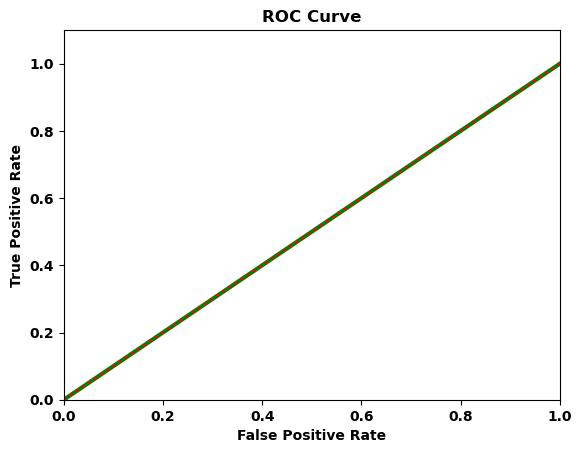

auc: 0.5


In [33]:
fpr,tpr,thres = metrics.roc_curve(test_y,test_y_predictions)
auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='green',lw=3)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print("auc:", auc)

**vi. Do your classes seem to be well-separated to cause instability in calculating
logistic regression parameters?**


Yes, very much so - we have far too few instances (69 for training, and 19 for testing) but there's 3 (features) x 3 (time series) x l (best split size), so anywhere from 9 to 180 classifications parameters to classify only 69 or 19 points. The logistic regression will thus likely be able to separate each class on some level with many more degrees of freedom remaining in its dimensions/parameters, so there is a lot of resulting instability in the logistic regression parameters. This instability is evidenced by the 
- large amount of warnings when max_iter (for SKLearn)/maxiter (for Statsmodels) is not manually set high, 
- NaN/high p-values for many parameters and the difference in coefficients for the parameters between the Statsmodels Logit function and the SKLearn -> implying a vast and unreliable confidence interval for the coefficients, due to class being very distinctly well-separated so the separation boundary isn't clear to the model
- huge amount of parameters chosen despite running RFE/RFECV

**vii. From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model.**

The confusion matrices show that the False Positive rate is high, due to only 4 samples that can be classified as True Negative - due to imbalanced classes. We know this to be true too, as only 13 of 88 instances across train and test belong to bending, whereas the rest are not bending.  
  
To correctly perform case-control sampling, I need to ensure that the test set is NOT resampled, and likewise the validation set is NOT resampled either, because we want to balance the training sets to better 'educate' our model, while testing its performance against realistic scenarios.

In [34]:
#these lists will give us the best results for all choices of l from 1 to 20
accuracy_list = []
best_features1 = []

for l in range(1,21): #for each choice of l
    
    #split our time series into equal sized groups using l as our split-size and generate our training data
    describe_df = pd.DataFrame()
    describe_df = get_instance_stats_binary_classification_bending_ksplits(
        train_df_bending, stats_type_list, describe_df, bending_status=1, k_splits=l)
    describe_df = get_instance_stats_binary_classification_bending_ksplits(
        train_df_not_bending, stats_type_list, describe_df, bending_status=0, k_splits=l)
    X_train = describe_df.drop('bending_status',axis=1)
    y_train = describe_df['bending_status']
    
    #create our 5-fold stratified cross-validation model first to be able to run recursive feature elimination on each fold
    #in order to determine the best predictor based on results of RFE on each fold.
        
    #run first logistic regression with recursive feature elimination
    #remove default L2-Regularization penalty (as suggested in footnote 3), set max_iter > default 100 to reduce instability
    lrm_one = LogisticRegression(penalty='none', max_iter=600) 
    selector = RFECV(estimator=lrm_one, cv=StratifiedKFold(5))
    selector = selector.fit(X_train,y_train)
    best_features = selector.fit(X_train,y_train).support_

    #run second logistic regression with prunes set of features
    #remove default L2-Regularization penalty (as suggested in footnote 3), set max_iter > default 100 to reduce instability
    lrm_two = LogisticRegression(penalty='none', max_iter=600)
    X_train = X_train.loc[:,best_features]
    lrm_two.fit(X_train,y_train)

    
    best_features1.append(X_train.columns.tolist())
    accuracy_list.append(lrm_two.score(X_train,y_train))

C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\karti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

NOTE: Scikit-Learn uses population standard deviation np.std(), whereas Pandas uses sample standard deviation, with n-ddof as the bessel correction term (default ddof=1). Thus, using StandardScalar() against my standardizing function gives slightly different values, but the difference is miniscule (noticeable when comparing both after the fourth decimal place). I don't think either approach is wrong here, since n=69 for training is n > 30, so population approximation should be okay but at the same time, 69 isn't a very big sample size.  
  
- https://stackoverflow.com/questions/44220290/sklearn-standardscaler-result-different-to-manual-result
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html
- You can find my screenshot of the observation and the slight difference between both methods in Piazza post @785